<footer id="footer"></footer>

<h1 align="center"><b>Исследование поведения пользователя мобильного приложения</b></h1>
<p align="center"><img src="https://i.ibb.co/7Xcnj8Z/ccbae7e460086c81959bf632728909a9.png" alt="ccbae7e460086c81959bf632728909a9" border="0"></p>


# Контекст  



Стартапу, который продаёт продукты питания, необходимо разобраться, как ведут себя пользователи мобильного приложения.  


- необходимо изучить воронку продаж и узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?  


-  исследовать результаты **A/A/B-эксперимента**. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам **A/A/B-теста**. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить , какой шрифт лучше.  




---
    
 <font size="1"> 
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов. </font>




<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


## Загрузка данных и первичный осмотр

<a id='data'></a>

Каждая запись в логе — это действие пользователя, или событие.  


`EventName` — название события;  
`DeviceIDHash` — уникальный идентификатор пользователя;  
`EventTimestamp` — время события;  
`ExpId` — номер эксперимента: `246` и `247` — контрольные группы, а `248` — экспериментальная.  

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sns
import pylab
import datetime
from scipy import stats as st
from plotly import graph_objects as go
import warnings
import math as mth
from statsmodels.stats.proportion import proportions_ztest
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")
pd.set_option('chained_assignment', None)
np.random.seed(42)


In [ ]:
def get_info(data):
    display(data.head())
    display(data.describe().T)
    print('----')
    print('Информация о пропусках и типах данных')
    print('----')
    print()
    data.info()
    print('----')
    print()

In [ ]:
def au_plot(data, metric):
    plt.figure(figsize=(15,5))
    data['uid'].plot(title=f'Уникальных пользователей по {metric}')
    plt.xlabel('Дата')
    plt.ylabel(metric)
    plt.show()

In [ ]:
def drop_column(data, columns):
    data_new = data.drop(columns, axis=1)
    return data_new

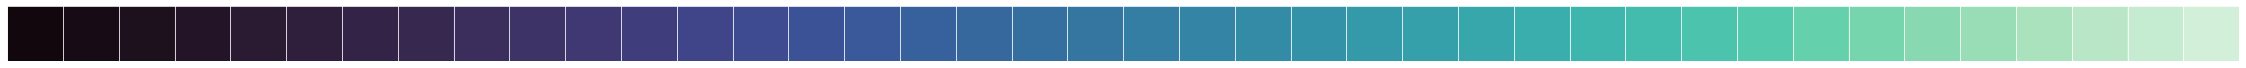

In [ ]:
current_palette = sns.color_palette('mako', 40)
sns.palplot(current_palette)

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Загрузка данных и предварительная обработка

In [ ]:
%%capture
!gdown --id 12CSJElh9-4VHDO5zZXguWzpSe6tjpU80

In [ ]:
try:
    path = '/content/logs_exp.csv'
    df = pd.read_csv(path, sep='\t')
except:
    path = '/datasets/logs_exp.csv'
    df = pd.read_csv(path, sep='\t')

In [ ]:
get_info(df)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


,count,mean,std,min,25%,50%,75%,max
DeviceIDHash,244126.0,4.627568e+18,2.642425e+18,6.888747e+15,2.372212e+18,4.623192e+18,6.932517e+18,9.222603e+18
EventTimestamp,244126.0,1.564914e+09,1.771343e+05,1.564030e+09,1.564757e+09,1.564919e+09,1.565075e+09,1.565213e+09
ExpId,244126.0,2.470223e+02,8.244339e-01,2.460000e+02,2.460000e+02,2.470000e+02,2.480000e+02,2.480000e+02


----
Информация о пропусках и типах данных
----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
----



Данные загружены, пропусков нет, как упоминалось [выше](#data), артибутивный состав:  



`EventName` — название события;  
`DeviceIDHash` — уникальный идентификатор пользователя;  
`EventTimestamp` — время события;  
`ExpId` — номер эксперимента: `246` и `247` — контрольные группы, а `248` — экспериментальная.  


Пропусков нет. `EventTimestamp` приведем к `datetime` для удобства работы. Также переимнуем названия признаков


Удалять столбец не будем, создадим новый - `event_date`

In [ ]:
df.columns= ['event_name', 'uid', 'event_timestamp', 'exp_id']
df['event_date'] = pd.to_datetime(df['event_timestamp'], unit='s')

In [ ]:
df.head()

,event_name,uid,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


In [ ]:
print(f'Количество дубликатов: {df.duplicated().sum()}')

Количество дубликатов: 413


Удалим дублирующиеся записи. Данных достаточно для анализа. Необходимо уточнить причину появления дубликатов

In [ ]:
logs = df.drop_duplicates().copy()
assert logs.duplicated().sum() == 0, 'Дубликаты не удалены'

In [ ]:
logs = (logs.assign(
                
                session_date = lambda x: x['event_date'].dt.date.astype('datetime64[D]'),
                session_week  = lambda x: x['event_date'].dt.week,
                session_month = lambda x: x['event_date'].dt.month,
                session_year = lambda x: x['event_date'].dt.year
                
                )
)

In [ ]:
logs.head()

,event_name,uid,event_timestamp,exp_id,event_date,session_date,session_week,session_month,session_year
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25,30,7,2019
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25,30,7,2019
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,30,7,2019
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25,30,7,2019
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25,30,7,2019


In [ ]:
delta = (max(logs['session_date']) - min(logs['session_date'])) / np.timedelta64(1, 'D')

print(f'Предоставлены данные за период в {delta + 1} дней')

Предоставлены данные за период в 14.0 дней


### Выводы  


Данные загружегны. Для удобства заменили названия признаков. Создали признак `event_date` - для удобства работы, типы данных `datetime`. Избавились от дубликатов, добавили также дополнительные столбцы для `даты сессии`, `недели`, `месяца` и `года`. В работе данные за 14 дней

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


## Исследование данных

Исследуем наши данные и попробуем ответить на следующие вопросы :  

- Сколько всего событий в логе?  
- Сколько всего пользователей в логе?  
- Сколько в среднем событий приходится на пользователя?  

In [ ]:
events = logs['event_name'].count()
users = logs['uid'].nunique()
print(f'В логе данных информация о {events} событиях и '
      f'содержит {users} уникальных пользователей')

В логе данных информация о 243713 событиях и содержит 7551 уникальных пользователей


In [ ]:
users_events = logs.groupby('uid')['event_name'].count()

mean_for_uid = round(users_events.mean(), 0)
med_for_uid = round(users_events.median(), 0)
mod_for_uid = round(users_events.mode()[0], 0)
print(f'В среднем, на каждого пользователя приходится {mean_for_uid} событий')
print(f'Медиана события на каждого пользователя - {med_for_uid} событий')
print(f'Мода для количества событий на каждого пользователя - {mod_for_uid} событий')

В среднем, на каждого пользователя приходится 32.0 событий
Медиана события на каждого пользователя - 20.0 событий
Мода для количества событий на каждого пользователя - 5 событий


In [ ]:
users_events.describe().to_frame('Значение')

,Значение
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


Среднее больше медианы, у данных будет перекос направо с длинным хвостом - есть выбросы. Посмотрим коробчатую диаграмму для значений событий на пользователя

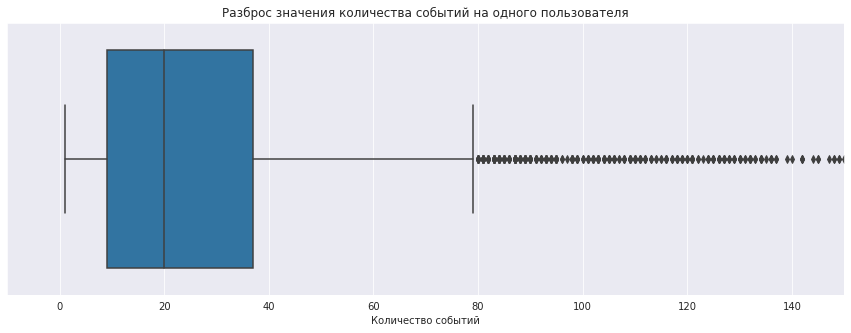

In [ ]:
plt.figure(figsize=(15, 5))
sns.boxplot(users_events)
plt.title('Разброс значения количества событий на одного пользователя')
plt.xlim(-10, 150)
plt.xlabel('Количество событий')
plt.show()

**Наши заключения подтверждаются:** значения количества событий на пользователя имеют ассиметричное распределение с длинным хвостом. В дальнейшем мы будем смотреть данные в разрезе количества пользователей на событие, а не количество событий на ползователя

In [ ]:
dau = logs.groupby('session_date').agg({'uid': 'nunique'})
print(f'Среднее DAU составляет  -  {int(dau.mean())} уникальных пользователей в день;')

Среднее DAU составляет  -  1944 уникальных пользователей в день;


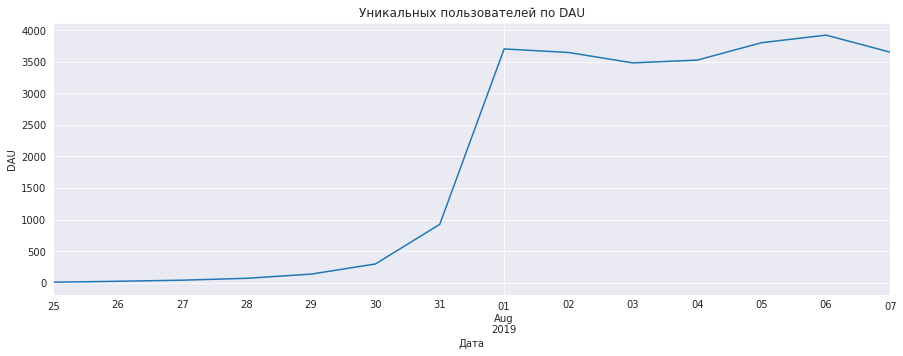

In [ ]:
au_plot(dau, 'DAU')

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Посмотрим на гистрограмму по датам. Довольно странный рост - у нас не было информации об открытии магазина

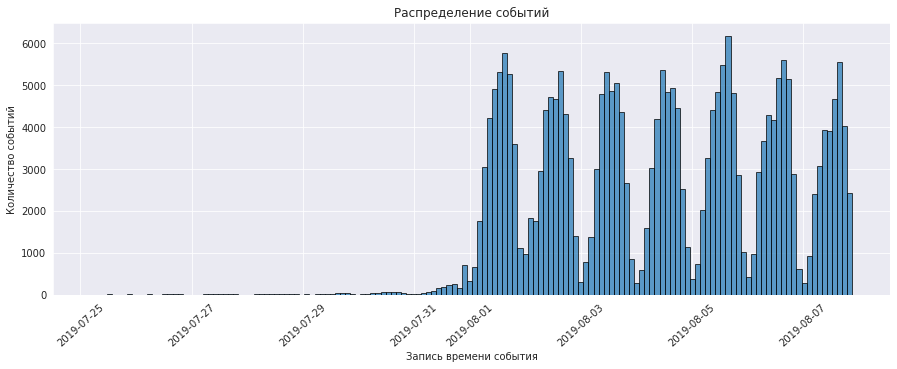

In [ ]:
plt.figure(figsize=(15, 5))

logs['event_date'].hist(bins=150, ec='black', alpha=.71)
plt.title('Распределение событий')
plt.xlabel('Запись времени события')
plt.ylabel('Количество событий')
plt.xticks(rotation=42)
plt.show()

Мы видим некоторый рост, который начинается между 31 июля 2019 года и 01 августа 2019 года. Посмотрим данный промежуток более подробно

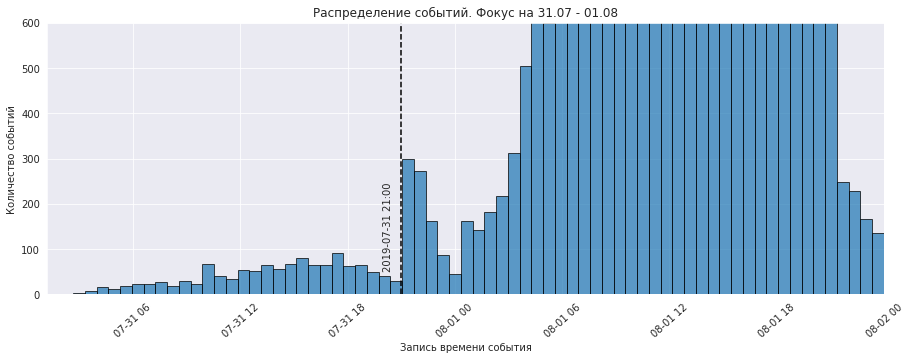

In [ ]:
min_date = logs.loc[logs['event_date'] >= '2019-07-31']['event_date'].min()
max_date = logs.loc[logs['event_date'] >= '2019-08-02']['event_date'].min()

plt.figure(figsize=(15, 5))

ax = logs['event_date'].hist(bins=500, ec='black', alpha=.71)
plt.title('Распределение событий. Фокус на 31.07 - 01.08')
plt.xlabel('Запись времени события')
plt.ylabel('Количество событий')
plt.xticks(rotation=42)
plt.xlim(left=min_date, right=max_date)

plt.vlines(x=datetime.datetime(2019, 7, 31, 21, 0), ymin=0, ymax=3000, linestyle='--')
plt.text(datetime.datetime(2019, 7, 31, 20, 0), 150, '2019-07-31 21:00', rotation=90, va='center')
plt.ylim(top=600)
plt.show()

Мы наблюдаем всплеск в `21:00 31.07.2019` года - это похоже на начало теста - начали поступать данные. Хвост похож на хвост остальны дневных гистограмм. Для того, чтобы не искажать анализ, уберем данные за июль до `21:00`

In [ ]:
logs_quer = logs.loc[logs['event_date'] >= '2019-07-31 21:00:00']

In [ ]:
logs_quer.head()

,event_name,uid,event_timestamp,exp_id,event_date,session_date,session_week,session_month,session_year
1990,MainScreenAppear,7701922487875823903,1564606857,247,2019-07-31 21:00:57,2019-07-31,31,7,2019
1991,MainScreenAppear,2539077412200498909,1564606905,247,2019-07-31 21:01:45,2019-07-31,31,7,2019
1992,OffersScreenAppear,3286987355161301427,1564606941,248,2019-07-31 21:02:21,2019-07-31,31,7,2019
1993,OffersScreenAppear,3187166762535343300,1564606943,247,2019-07-31 21:02:23,2019-07-31,31,7,2019
1994,MainScreenAppear,1118952406011435924,1564607005,248,2019-07-31 21:03:25,2019-07-31,31,7,2019


Таким образом, получили новый сет данных с пользователями начиная с 21 часа 31 июля 2019 года. Посмотрим снова на гистограмму:

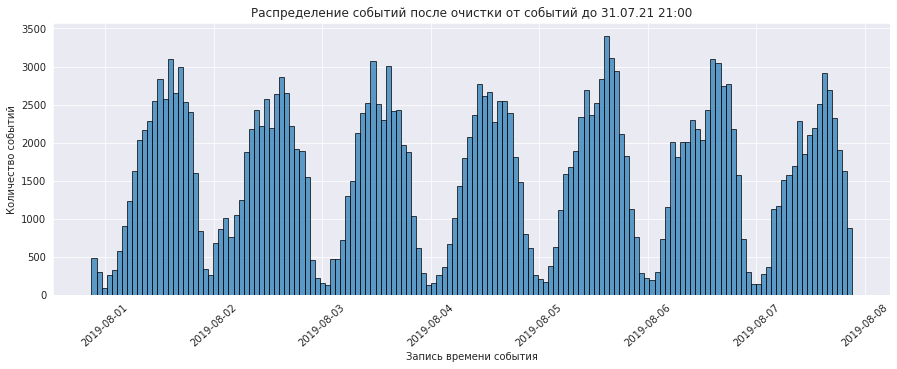

In [ ]:
plt.figure(figsize=(15, 5))

logs_quer['event_date'].hist(bins=150, ec='black', alpha=.71)
plt.title('Распределение событий после очистки от событий до 31.07.21 21:00')
plt.xlabel('Запись времени события')
plt.ylabel('Количество событий')
plt.xticks(rotation=42)
plt.show()

Получили ожидаемый результат, но нам необходимо проверить, что с нашими пользователями и событиями в логе, по сравнению с первыми выводами:

In [ ]:
events_q = logs_quer['event_name'].count()
users_q = logs_quer['uid'].nunique()
print(f'В логе данных информации о событиях стало {events_q} событий (ранее - {events}) и '
      f'содержится {users_q} уникальных пользователей вместо {users} ')

print(f'Удалили информацию о {events-events_q} ({1 - events_q/events:.2%}) событиях'
      f' и {users-users_q} ({1 - users_q/users:.2%}) пользователях')

В логе данных информации о событиях стало 241724 событий (ранее - 243713) и содержится 7538 уникальных пользователей вместо 7551 
Удалили информацию о 1989 (0.82%) событиях и 13 (0.17%) пользователях


Мы не потеряли много данных. Решение корректное

In [ ]:
sessions_by_day = int(logs_quer.groupby(['session_date']).agg({'uid':['count']}).mean())
print(f'Среднее количество сессий в день составляет: {sessions_by_day}')

Среднее количество сессий в день составляет: 30215


Достаточно внушительный показатель. Посчитаем среднее количество сессия в день на пользователя

In [ ]:
sess_per_user = logs_quer.groupby(['session_date', 'uid']).agg({'event_date': 'count'})
sess_per_user = sess_per_user.groupby('session_date').agg({'event_date': 'mean'})
cnt = round(sess_per_user['event_date'].mean(), 2)
print(f'Среднее количество сессий в день на пользователя: {cnt}')

Среднее количество сессий в день на пользователя: 8.85


In [ ]:
logs_quer.groupby(['exp_id'], as_index=False)['uid'].nunique().assign(
    user_sum = lambda x: x['uid'].sum(),
    pct = lambda x: round(x['uid'] / x['user_sum'] * 100, 2)

)

,exp_id,uid,user_sum,pct
0,246,2484,7538,32.95
1,247,2517,7538,33.39
2,248,2537,7538,33.66


В группах содержится примерно одинаковое количество уникальных пользователей. В данных представителии всех трех групп

### Выводы  


В процессе исследования выявили аномалию. Удалили информацию о 1989 (0.82%) событиях и 13 (0.17%) пользователях. При этом процентное соотношение представителей групп - примерно равно. Нам необходимо проанализировать воронку событий, дальше приступим к исследованию наших групп


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


## Изучение воронки событий

Посмотрим, какие события есть в логах и как часто они встречаются

In [ ]:
(logs_quer
 .groupby('event_name', as_index=False)['uid']
 .count()
 .rename(columns={'uid':'cnt'})
 .sort_values(by='cnt', ascending=False)
 .style.set_caption('Событие и количетво в логе')
 .set_precision(2)
 .background_gradient(low=0)
 
 )
 

,event_name,cnt
1,MainScreenAppear,117889
2,OffersScreenAppear,46531
0,CartScreenAppear,42343
3,PaymentScreenSuccessful,33951
4,Tutorial,1010


В логе представлено пять различных событий.

`MainScreenAppear` - событие, связанное с появлением пользователя на главном экране  
`OffersScreenAppear` - событие, связанное с появлениемкакого-либо предложения  
`CartScreenAppear` - посещение корзины  
`PaymentScreenSuccessful` - оплата товара  
`Tutorial` - прохождение обучения  - неизвестно, является ли туториал обязательным или нет. Стоит ли вообще включать его в воронку - необходимо также обдумать этот вопрос.

Посмотрим по уникальным пользователямю Также добавим пользователей на начало, то есть перед событием `MainScreenAppear`

In [ ]:
init_users = pd.Series({
            'event_name': 'Total',
            'uid_cnt': logs_quer['uid'].nunique()})


unique_users = (logs_quer.groupby('event_name')['uid']
                .nunique()
                .reset_index()
                .rename(columns={'uid':'uid_cnt'})
                .append(init_users, ignore_index=True)
                .sort_values(by='uid_cnt', ascending=False)
                .reset_index(drop=True)

               )

In [ ]:
(unique_users.style.set_caption('Событие и количество пользователей')
                   .set_precision(2)
                   .background_gradient(low=0)
)

,event_name,uid_cnt
0,Total,7538
1,MainScreenAppear,7423
2,OffersScreenAppear,4597
3,CartScreenAppear,3736
4,PaymentScreenSuccessful,3540
5,Tutorial,843


In [ ]:
uid_event_cnt = logs_quer.groupby('uid')['event_name'].nunique().reset_index().rename(columns={'event_name':'event_cnt'})
uid_all_events = uid_event_cnt.loc[uid_event_cnt['event_cnt'] > 4]['uid'].count()

In [ ]:
print(f'Количество пользователей, совершавших все события {uid_all_events} человек')
print(f'Доля таких пользователей {round(uid_all_events * 100.0 / uid_event_cnt.shape[0], 2)} %')

Количество пользователей, совершавших все события 469 человек
Доля таких пользователей 6.22 %


In [ ]:
user_single_event = (
    uid_event_cnt[uid_event_cnt['event_cnt'] == 1]['uid'].count() 
    / len(logs['uid'].unique()))

In [ ]:
print(f'Доля пользователей, совершивших только одно действие {round(user_single_event * 100, 2)} %')

Доля пользователей, совершивших только одно действие 35.98 %


Достаточно много. Посмотрим пользователей по событиям и откинем тех, у кого в записи отсутствует главный экран

In [ ]:
event = ['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
for event in event:
    step = uid_event_cnt[uid_event_cnt['event_cnt'] == 1]['uid']
    single_offers = logs_quer.loc[(logs_quer['uid'].isin(step))
          & (logs_quer['event_name'] == event)]
    print(event, single_offers.shape[0])

OffersScreenAppear 29
CartScreenAppear 0
PaymentScreenSuccessful 0


Для рассчета воронки, не будем использовать `Tutorial`.   

Но перед этим, стоит удалить пользователей, у которых единственное действие - `OffersScreenAppear`. Предполагаю, что данное событие, может произойти только после посещения главного экрана. Удалим эти события и проверим снова количество групп

In [ ]:
step = uid_event_cnt[uid_event_cnt['event_cnt'] == 1]['uid']
single_offers = logs_quer.loc[(logs_quer['uid'].isin(step))
        & (logs_quer['event_name'] == 'OffersScreenAppear')]

Удалим лишних пользователей, также уберем `Tutorial`

In [ ]:
logs_fin = logs_quer.loc[~logs_quer['uid'].isin(single_offers['uid'])]
logs_fin = logs_fin.loc[logs_fin['event_name'] != 'Tutorial']

In [ ]:
logs_fin.groupby(['exp_id'], as_index=False)['uid'].nunique().assign(
    user_sum = lambda x: x['uid'].sum(),
    pct = lambda x: round(x['uid'] / x['user_sum'] * 100, 2)

)

,exp_id,uid,user_sum,pct
0,246,2480,7523,32.97
1,247,2511,7523,33.38
2,248,2532,7523,33.66


Группы сильно не исказили. Можем смотреть воронку

In [ ]:
aab_logs = logs_fin.copy()

init_users = pd.Series({
            'event_name': 'Total',
            'uid_cnt': aab_logs['uid'].nunique()})


unique_users = (aab_logs.groupby('event_name')['uid']
                .nunique()
                .reset_index()
                .rename(columns={'uid':'uid_cnt'})
                .append(init_users, ignore_index=True)
                .sort_values(by='uid_cnt', ascending=False)
                .reset_index(drop=True)

               )

Стоит отметить, что при группировке по событиям, мы получили 4 дополнительных пользователя уникальных, при этом в случае группировки по группам - общая сумма пользователей `7523` против `7527`. необходимо будет провести проверку, не попали ли одинаковые пользователи в разные группы

In [ ]:
unique_users

,event_name,uid_cnt
0,Total,7523
1,MainScreenAppear,7423
2,OffersScreenAppear,4586
3,CartScreenAppear,3736
4,PaymentScreenSuccessful,3540


In [ ]:
funnel = unique_users.copy()

Изобразим нашу воронку с помощью средств `plt`, чтобы не было проблем с окружением

In [ ]:
fig = go.Figure(go.Funnel(
                y = funnel['event_name'],
                x = funnel['uid_cnt'],
                textinfo = "value+percent previous+percent initial",
                marker = {"color": ["deepskyblue", "royalblue", "darkcyan", "cadetblue", "silver"]})
                     
)
fig.show()

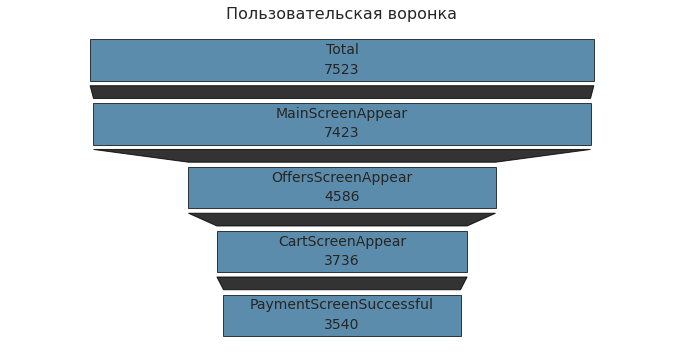

In [ ]:
funnel = funnel.assign(
    
    lag = lambda x: x['uid_cnt'].shift().replace(np.nan, x['uid_cnt'].max()),
    pct = lambda x: round(x['uid_cnt'] * 100 / x['lag'], 2),
    diff = lambda x: round(abs(x['uid_cnt'].diff() * 100 / x['lag'])).replace(np.nan, 0)
    
    ).pipe(drop_column, 'lag')


In [ ]:
funnel

,event_name,uid_cnt,pct,diff
0,Total,7523,100.00,0.0
1,MainScreenAppear,7423,98.67,1.0
2,OffersScreenAppear,4586,61.78,38.0
3,CartScreenAppear,3736,81.47,19.0
4,PaymentScreenSuccessful,3540,94.75,5.0


Больше всего пользователей уходит после главного экрана - `38%`. 

`19%` мы теряем на этапе перехода от предложения до корзины. `5%` теряем на оплате

In [ ]:
pct_all = (funnel['uid_cnt'].iloc[4] / funnel['uid_cnt'].iloc[0])

In [ ]:
print('Доля пользователей, оплативших товар {:.0%}'.format(pct_all))

Доля пользователей, оплативших товар 47%


### Выводы  


В логе представлено пять различных событий.

`MainScreenAppear` - событие, связанное с появлением пользователя на главном экране  
`OffersScreenAppear` - событие, связанное с появлениемкакого-либо предложения  
`CartScreenAppear` - посещение корзины  
`PaymentScreenSuccessful` - оплата товара  
`Tutorial` - прохождение обучения

Количество пользователей, совершавших все события 469 человек
Доля таких пользователей 6.22 %


Доля пользователей, оплативших товар 47%

Было принято решение удалить 29 пользователей, у которых значилось только событие `OffersScreenAppear`


Можем переходить неспоредственно к анализу результатов теста


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


## Исследование результата эксперимента

Посмотрим на наши группы. Обучение `Tutorial` мы уже убрали

In [ ]:
aab_logs.head()

,event_name,uid,event_timestamp,exp_id,event_date,session_date,session_week,session_month,session_year
1990,MainScreenAppear,7701922487875823903,1564606857,247,2019-07-31 21:00:57,2019-07-31,31,7,2019
1991,MainScreenAppear,2539077412200498909,1564606905,247,2019-07-31 21:01:45,2019-07-31,31,7,2019
1992,OffersScreenAppear,3286987355161301427,1564606941,248,2019-07-31 21:02:21,2019-07-31,31,7,2019
1993,OffersScreenAppear,3187166762535343300,1564606943,247,2019-07-31 21:02:23,2019-07-31,31,7,2019
1994,MainScreenAppear,1118952406011435924,1564607005,248,2019-07-31 21:03:25,2019-07-31,31,7,2019


In [ ]:
groups = aab_logs.groupby(['exp_id'], as_index=False).agg({'uid':'nunique'}).assign(
    user_sum = lambda x: x['uid'].sum(),
    pct = lambda x: round(x['uid'] / x['user_sum'] * 100, 2)

).pipe(drop_column, 'user_sum')

Расхождения незначительные, но перед тем, как приступать к анализу проведенного `А/В-теста`, проверим, не попали ли одни и теже пользователи в разные группы - таких пользователей будем исключать, чтобы не искажать результаты теста. 

In [ ]:
visitors_a1_cnt = aab_logs.query('exp_id == 246')['uid'].shape[0]
visitors_a2_cnt = aab_logs.query('exp_id == 247')['uid'].shape[0]
visitors_b_cnt = aab_logs.query('exp_id == 248')['uid'].shape[0]

print(f'Визитов по группе А1 {visitors_a1_cnt}')
print(f'Визитов по группе А2 {visitors_a2_cnt}')
print(f'Визитов по группе В {visitors_b_cnt}')

Визитов по группе А1 79233
Визитов по группе А2 76935
Визитов по группе В 84517


In [ ]:
visitors_unique_A1 = aab_logs[aab_logs['exp_id']==246]['uid']
visitors_unique_A2 = aab_logs[aab_logs['exp_id']==247]['uid']
visitors_unique_B = aab_logs[aab_logs['exp_id']==248]['uid']


step_1 = (aab_logs['uid'].isin(visitors_unique_A1))
step_2 = (aab_logs['uid'].isin(visitors_unique_A2))
step_3 = (aab_logs['uid'].isin(visitors_unique_B))

visitors_A_A_B = (aab_logs
                    .loc[(step_1 & step_2)
                     | (step_1 & step_3)
                     | (step_2 & step_3)
                     | (step_1 & step_3 & step_2),'uid'].unique()
                    )
print(f'Количество пользователей, попавших в несколько групп: {len(visitors_A_A_B)}')

Количество пользователей, попавших в несколько групп: 0


Пользователей, попавших в одинаковые группы не обнаружено

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### A/A проверка

С данными все хорошо. Для начала займемся двумя `А/А` группами - `246` и `247`. Выберем самое популярное событие и посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие и проверим, будет ли отличие между группами статистически достоверным. 

Получим список событий

In [ ]:
event_list = funnel['event_name'].unique().tolist()

In [ ]:
event_list

['Total',
 'MainScreenAppear',
 'OffersScreenAppear',
 'CartScreenAppear',
 'PaymentScreenSuccessful']

Сформируем сводную таблицу по нашим группам

In [ ]:
aab_logs.head()

,event_name,uid,event_timestamp,exp_id,event_date,session_date,session_week,session_month,session_year
1990,MainScreenAppear,7701922487875823903,1564606857,247,2019-07-31 21:00:57,2019-07-31,31,7,2019
1991,MainScreenAppear,2539077412200498909,1564606905,247,2019-07-31 21:01:45,2019-07-31,31,7,2019
1992,OffersScreenAppear,3286987355161301427,1564606941,248,2019-07-31 21:02:21,2019-07-31,31,7,2019
1993,OffersScreenAppear,3187166762535343300,1564606943,247,2019-07-31 21:02:23,2019-07-31,31,7,2019
1994,MainScreenAppear,1118952406011435924,1564607005,248,2019-07-31 21:03:25,2019-07-31,31,7,2019


In [ ]:
groups = aab_logs.groupby(['exp_id'])['uid'].nunique().reset_index().assign(
    user_sum = lambda x: x['uid'].sum()
)

In [ ]:
groups

,exp_id,uid,user_sum
0,246,2480,7523
1,247,2511,7523
2,248,2532,7523


Возьмем событие `MainScreenAppear` и проверим гипотезу о равенстве двух долей.

`H0 гипотеза`: статистически значимых различий конверсии в `MainScreenAppear` от общего числа пользователей между группами нет  
`H1 гипотеза`: статистически значимые различия конверсии в `MainScreenAppear` от общего числа пользователей обнаружены между группами

Сформируем образцы для контрольных групп 246 и 247 - количество уникальных пользователей

In [ ]:
success_246 = (aab_logs.loc[(aab_logs['event_name'] == 'MainScreenAppear') & (aab_logs['exp_id'] == 246)])['uid'].nunique()
success_247 = (aab_logs.loc[(aab_logs['event_name'] == 'MainScreenAppear') & (aab_logs['exp_id'] == 247)])['uid'].nunique()
trials_246 = groups.loc[groups['exp_id'] == 246]['uid'][0]
trials_247 = groups.loc[groups['exp_id'] == 247]['uid'][1]

In [ ]:
print('Доля пользователей, совершивших действие для группы 246 - {:.2%}'.format(success_246/trials_246))
print('Доля пользователей, совершивших действие для группы 247 - {:.2%}'.format(success_247/trials_247))

Доля пользователей, совершивших действие для группы 246 - 98.79%
Доля пользователей, совершивших действие для группы 247 - 98.73%


Проверим наши гипотезы с помощью `z-test`. Альфу обозначим как `.05, после всех сравнений, введем поправку Бонферрони` и проведем исследование еще раз

In [ ]:
alpha = .05

success = np.array([success_246, success_247])
trials = np.array([trials_246, trials_247])
stat, pval = proportions_ztest(success, trials, alternative='two-sided')

if pval < alpha:
    print(f"{round(pval, 2)}. Отвергаем Н0")
else:
    print(f"{round(pval, 2)}. Не отвергаем Н0. События могут носить случайный характер")

0.84. Не отвергаем Н0. События могут носить случайный характер


Для удобства, добавим функцию и проведем проверки других событий

In [ ]:
def make_z_test(group_1, group_2, event, previous_event, alpha, concat=False, bonferroni=None):
    inv_map = {v: k for k, v in dict(groups['exp_id']).items()}
    
    print('\nГипотезы:')

    print(f'H0 гипотеза: статистически значимых различий конверсии в {event}' 
          ' от общего числа пользователей между группами нет')
    print(f'H1 гипотеза: статистически значимых различий конверсии в {event}'
          ' от общего числа пользователей обнаружены между группами')

    if concat:

        group_3 = 247
        step = (aab_logs['event_name'] == event)
        success_1 = (aab_logs.loc[(step & (aab_logs['exp_id'] == group_1)) 
                                  | (step & (aab_logs['exp_id'] == group_3))]['uid'].nunique()
                    )
        success_2 = (aab_logs.loc[(aab_logs['event_name'] == event) & (aab_logs['exp_id'] == group_2)])['uid'].nunique()

        trials_1 = groups.loc[(groups['exp_id'] == group_1) | (groups['exp_id'] == group_3)]['uid'].sum()
        trials_2 = groups.loc[groups['exp_id'] == group_2]['uid'][inv_map[group_2]]

        print(f'\nДоля пользователей, совершивших переход на экран {event} с экрана {previous_event}'
              f' для группы {group_1} и {group_3} - {success_1/trials_1:.2%}')
        print(f'Доля пользователей, совершивших переход на экран {event} с экрана {previous_event}'
            f' для группы {group_2} - {success_2/trials_2:.2%}')

    else:

        success_1 = (aab_logs.loc[(aab_logs['event_name'] == event) & (aab_logs['exp_id'] == group_1)])['uid'].nunique()
        success_2 = (aab_logs.loc[(aab_logs['event_name'] == event) & (aab_logs['exp_id'] == group_2)])['uid'].nunique()
        trials_1 = groups.loc[groups['exp_id'] == group_1]['uid'][inv_map[group_1]]
        trials_2 = groups.loc[groups['exp_id'] == group_2]['uid'][inv_map[group_2]]
        print(f'\nДоля пользователей, совершивших переход на экран {event} с экрана {previous_event}'
              f' для группы {group_1} - {success_1/trials_1:.2%}')
        print(f'Доля пользователей, совершивших переход на экран {event} с экрана {previous_event}'
              f' для группы {group_2} - {success_2/trials_2:.2%}')
  
    diff = ((success_2 / trials_2) / (success_1 / trials_1) - 1)
    success = np.array([success_1, success_2])
    trials = np.array([trials_1, trials_2])
    stat, pval = proportions_ztest(success, trials, alternative='two-sided')

    if bonferroni is not None:
        bonferroni_alpha = alpha / bonferroni
        alpha = bonferroni_alpha
    else:
        alpha = alpha

    if pval < alpha:
        print(f"\npvalue {pval}. \n\nОтвергаем Н0. \n\nПри alpha {alpha}")
    else:
        print(f"\npvalue {pval}. \n\nНе отвергаем Н0. \n\nСобытия могут носить случайный характер. При alpha {alpha}")
    print(f'Относительное различие групп {diff:.2%}')

Проведем тесты в рамках конверсии на тот или иной экран от общего числа пользователей:

In [ ]:
counter = 0

In [ ]:
for idx, event in enumerate(event_list):
    if event == 'Total':
        continue
    else:
        print(f'\nТест № {idx} для события: {event}')
        prev = event_list[idx - 1]
        make_z_test(246, 247, event, prev, alpha=.05)
        counter += 1


Тест № 1 для события: MainScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 246 - 98.79%
Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 247 - 98.73%

pvalue 0.8364915785175109. 

Не отвергаем Н0. 

События могут носить случайный характер. При alpha 0.05
Относительное различие групп -0.07%

Тест № 2 для события: OffersScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершивших п

При показателе `alpha=.05` мы не обнаружили статистически значимых различий между двумя контрольными группами. Разбиение сработало корректно. Проведем все исследования. Затем учтем количество сравнений в поправке Бонферрони

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### A/B проверка. 

#### Группы 246/248

Провдем аналогичную проверку, для контрольной 246 группы и тестовой группы 248. И аналогично для 247/248

In [ ]:
for idx, event in enumerate(event_list):
    if event == 'Total':
        continue
    else:
        print(f'\nТест № {idx} для события: {event}')
        prev = event_list[idx - 1]
        make_z_test(246, 248, event, prev, alpha=.05)
        counter += 1


Тест № 1 для события: MainScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 246 - 98.79%
Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 248 - 98.50%

pvalue 0.37309135448254493. 

Не отвергаем Н0. 

События могут носить случайный характер. При alpha 0.05
Относительное различие групп -0.29%

Тест № 2 для события: OffersScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершивших 

Не отвергли нулевую гипотзу.  Статистически важных различий не выявлено

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


#### Группы 247/248

Провдем проверку, для контрольной 247 группы и тестовой группы 248

In [ ]:
for idx, event in enumerate(event_list):
    if event == 'Total':
        continue
    else:
        print(f'\nТест № {idx} для события: {event}')
        prev = event_list[idx - 1]
        make_z_test(247, 248, event, prev, alpha=.05)
        counter += 1


Тест № 1 для события: MainScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 247 - 98.73%
Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 248 - 98.50%

pvalue 0.49202711407845534. 

Не отвергаем Н0. 

События могут носить случайный характер. При alpha 0.05
Относительное различие групп -0.23%

Тест № 2 для события: OffersScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершивших 

Не отвергли нулевые гипотезы.  Статистически важных различий не выявлено

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### A/A/B тестирование

Объединим АА группы в одну. Проведем тесты при альфа .05

In [ ]:
for idx, event in enumerate(event_list):
    if event == 'Total':
        continue
    else:
        print(f'\nТест № {idx} для события: {event}')
        prev = event_list[idx - 1]
        make_z_test(246, 248, event, prev, alpha=.05, concat=True)
        counter += 1


Тест № 1 для события: MainScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 246 и 247 - 98.76%
Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 248 - 98.50%

pvalue 0.3548099811698696. 

Не отвергаем Н0. 

События могут носить случайный характер. При alpha 0.05
Относительное различие групп -0.26%

Тест № 2 для события: OffersScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, соверши

Даже с объединенной группой А мы не отвергаем нулевую гипотезу

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Тестирование с поправкой Бонферрони

Мы множественное сравнение, нам необходимо провести испытания с поправкой Бонферрони. Проведем испытания снова

In [ ]:
print(f'Количество проведенных сравнение: {counter}')

Количество проведенных сравнение: 16


#### Группы 246/248

Повторно проверим группы 246 и 248

In [ ]:
for idx, event in enumerate(event_list):
    if event == 'Total':
        continue
    else:
        print(f'\nТест № {idx} для события: {event}')
        prev = event_list[idx - 1]
        make_z_test(246, 248, event, prev, alpha=.05, bonferroni=counter)


Тест № 1 для события: MainScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 246 - 98.79%
Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 248 - 98.50%

pvalue 0.37309135448254493. 

Не отвергаем Н0. 

События могут носить случайный характер. При alpha 0.003125
Относительное различие групп -0.29%

Тест № 2 для события: OffersScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершив

Также не смогли отвергнуть нулевую гипотезу

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


#### Группы 247/248

Аналогично сделаем для групп 247 и 248

In [ ]:
for idx, event in enumerate(event_list):
    if event == 'Total':
        continue
    else:
        print(f'\nТест № {idx} для события: {event}')
        prev = event_list[idx - 1]
        make_z_test(247, 248, event, prev, alpha=.05, bonferroni=counter)


Тест № 1 для события: MainScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 247 - 98.73%
Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 248 - 98.50%

pvalue 0.49202711407845534. 

Не отвергаем Н0. 

События могут носить случайный характер. При alpha 0.003125
Относительное различие групп -0.23%

Тест № 2 для события: OffersScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершив

С поправкой мы не отвергли нулевую гипотезу

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


#### Группы 246/247

In [ ]:
for idx, event in enumerate(event_list):
    if event == 'Total':
        continue
    else:
        print(f'\nТест № {idx} для события: {event}')
        prev = event_list[idx - 1]
        make_z_test(246, 247, event, prev, alpha=.05, bonferroni=counter)


Тест № 1 для события: MainScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 246 - 98.79%
Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 247 - 98.73%

pvalue 0.8364915785175109. 

Не отвергаем Н0. 

События могут носить случайный характер. При alpha 0.003125
Относительное различие групп -0.07%

Тест № 2 для события: OffersScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершивш

Здесь аналогично - не смогли отвергнуть нулевую гипотезу

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### A/A/B тестирование с поправкой Бонферрони

In [ ]:
for idx, event in enumerate(event_list):
    if event == 'Total':
        continue
    else:
        print(f'\nТест № {idx} для события: {event}')
        prev = event_list[idx - 1]
        make_z_test(246, 248, event, prev, alpha=.05, concat=True, bonferroni=counter)


Тест № 1 для события: MainScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в MainScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 246 и 247 - 98.76%
Доля пользователей, совершивших переход на экран MainScreenAppear с экрана Total для группы 248 - 98.50%

pvalue 0.3548099811698696. 

Не отвергаем Н0. 

События могут носить случайный характер. При alpha 0.003125
Относительное различие групп -0.26%

Тест № 2 для события: OffersScreenAppear

Гипотезы:
H0 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей между группами нет
H1 гипотеза: статистически значимых различий конверсии в OffersScreenAppear от общего числа пользователей обнаружены между группами

Доля пользователей, сов

Аналогично, с объединенной группой А и поправкой - мы не отвергаем нулевую гипотезу

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Выводы  

В общей сложности мы провели 16 сравнений: `12` на базовые группы 246, 247 и 248, а также `4` сравнение на объединенную группу 246 и 247 против 248.   


По итогам сравнения групп, статистически значимых различий, свидетельствующих нам о важности изменения шрифта в приложении - не выявлено

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


## Вывод  



Стартапу, который продаёт продукты питания, необходимо было разобраться, как ведут себя пользователи мобильного приложения. Нами быа изучена воронка продаж и найдем путь пользователя до оплаты

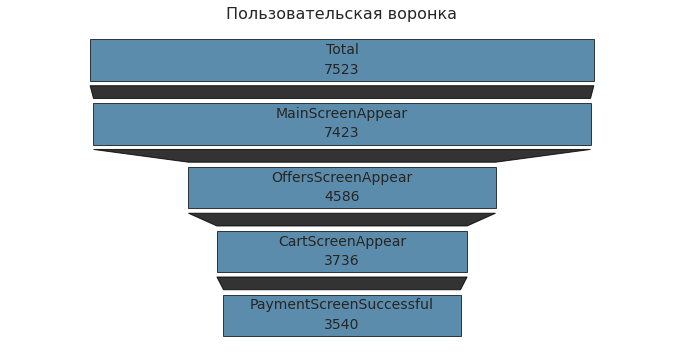

Больше всего пользователей уходит после главного экрана - 38%.  
19% мы теряем на этапе перехода от предложения до корзины. 5% теряем на оплате

Также, по результатам исследования результатов A/A/B теста - статистически важных различий не выявлено. Таким образом, изменение шрифта в мобильном приложении не оказывает влияние на пользователя, как итог - он не лучше и не хуже старого образца шрифта. Таким образом, изменение шрифта не является необходимым. Можно остановить тест

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>
